In [1]:
# Import for database connection and other basic libraries
import mysql.connector
import pandas as pd
import numpy as np
import os
import re
from sqlalchemy import create_engine
from dotenv import load_dotenv


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

from imblearn.over_sampling import RandomOverSampler

# Import libraries for LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

load_dotenv()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joelleng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joelleng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joelleng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joelleng/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Connect to data warehouse

In [2]:
dwh_host = os.getenv("DATAWH_ENDPOINT")
dwh_user = os.getenv("DATAWH_USERNAME")
dwh_pw = os.getenv("DATAWH_PASSWORD")
dwh_name = os.getenv("DATAWH_NAME")
dwh_port = os.getenv("DATAWH_PORT")

# db_datawarehouse = mysql.connector.connect(
#     host=dwh_host,
#     user=dwh_user,
#     passwd=dwh_pw,
#     database=dwh_name
# )

engine = create_engine(f'mysql://{dwh_user}:{dwh_pw}@{dwh_host}:{dwh_port}/{dwh_name}', echo=False, future=True)
db_datawarehouse = engine.connect()

## Set up for LSTM
1) CUDA usage
2) Load dataset and to train test split
    - Utilise the temporal dimension of our data to conduct dataset splot, we will split it into 80/10/10 of train set, test set and val set respectively

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
df = pd.read_sql_table('review', db_datawarehouse).copy()
df = df.drop(columns=['index'])
#print([data['Rating'].value_counts(), data['Text_Sentiment'].value_counts(), data['Title_Sentiment'].value_counts()])

In [5]:
data = df[['ReviewText', 'DateOfStay', 'Text_Sentiment']]
train_data = data[data['DateOfStay'].apply(lambda x: int(x.split('-')[0])) < 2022]
test_data = data[data['DateOfStay'].apply(lambda x: int(x.split('-')[0])) >= 2022]
X_trainset, y_trainset = train_data['ReviewText'].values, train_data['Text_Sentiment'].values
X_test_val, y_test_val = test_data['ReviewText'].values, test_data['Text_Sentiment'].values
X_testset, X_valset, y_testset, y_valset = train_test_split(X_test_val, y_test_val, test_size=0.5)

print(f'Shape of train data is {X_trainset.shape} and {y_trainset.shape}')
print(f'Shape of test data is {X_testset.shape} and {y_testset.shape}')
print(f'Shape of val data is {X_valset.shape} and {y_valset.shape}')

Shape of train data is (10045,) and (10045,)
Shape of test data is (593,) and (593,)
Shape of val data is (594,) and (594,)


In [6]:
# Testing data
print('\n Text input: {}\n'.format(X_trainset[0]))
print('\n Text input: {}\n'.format(X_trainset[1]))
print('\n Text input: {}\n'.format(X_trainset[2]))




 Text input: Due to the pandemic and the fluid nature of border restrictions, we opted to spend our anniversary this year in Singapore again.      We opted for 3 separate staycations and, in order to compare the hotels we 've chosen, the duration for each of our staycations was the same duration and over the same days of different weeks.    Marina Bay Sands was our second staycation.    We had stayed once before but that memory was become fuzzy.  All I could remember was that the restroom was huge.    Actually we didn 't plan to stay at the MBS.  However, due to the availability of a promotion, we decided to have our second staycation there  u2013 and boy were we glad we did.    We always opt for rooms with club benefits.  However, during the period of our staycation, all the rooms with club access were under renovation and only suites were available.  I decided against going for a suite since we would probably just stay on bed the whole time and would not be able to justify the hefty

## Feature Engineering for LSTM

In [7]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def process_text(text):
    
    # Initialise
    lemmatizer = WordNetLemmatizer()
    edited_stop_words = stopwords.words('english')
    processed_text = " "
    
    # Process input
    text_lower = text.lower()
    word = word_tokenize(text_lower)
    
    # Alphabetical Tokens
    alphabetic_tokens = [preprocess_string(word) for word in word if re.match('^[a-zA-Z]+$', word)]
    
    print(alphabetic_tokens)

    # Edit stopwords list
    edited_stop_words.remove('no')
    edited_stop_words.remove('not')
    edited_stop_words.remove("wouldn't")
    edited_stop_words.remove('wouldn')
    edited_stop_words.remove("couldn't")
    edited_stop_words.remove('couldn')
    edited_stop_words.remove("against")
    
    # Remove stopwords from text and lemmatize
    stop_words = set(edited_stop_words)
    
    lem_words = []
    for word in alphabetic_tokens:
        if word not in stop_words:
            lem_words.append(lemmatizer.lemmatize(word))
    
    # Join the list of words
    processed_text = processed_text.join(lem_words)     #print(edited_stop_words)

    return processed_text

def tokenize(x_train, x_test, x_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        # print(type(sent)) 'str'
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of 1000 most common words.
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train, final_list_test, final_list_val = [], [], []
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    for sent in x_val:
            final_list_val.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train, dtype=object), np.array(final_list_test, dtype=object), np.array(final_list_val, dtype=object), onehot_dict

X_train, X_test, X_val , vocab = tokenize(X_trainset, X_testset, X_valset)
y_train, y_test, y_val = y_trainset, y_testset, y_valset

Analysing and visualising the length of the preprocessed text

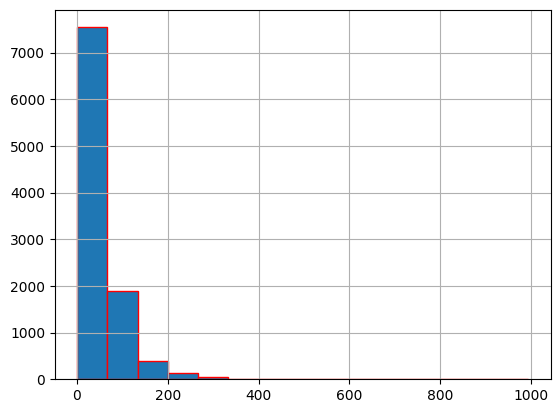

count    10045.000000
mean        55.226481
std         49.119345
min          1.000000
25%         25.000000
50%         40.000000
75%         67.000000
max        994.000000
dtype: float64

In [8]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist(bins=15, edgecolor="red")
plt.show()
pd.Series(rev_len).describe()

In [9]:
print('\n Text input: {}\n'.format(X_train[0]))


 Text input: [254, 216, 571, 392, 7, 436, 497, 75, 186, 262, 21, 6, 33, 331, 446, 24, 48, 633, 51, 292, 853, 5, 46, 73, 254, 272, 331, 446, 156, 500, 116, 22, 41, 73, 446, 22, 41, 68, 859, 234, 272, 146, 112, 266, 16, 252, 5, 104, 232, 15, 16, 188, 201, 317, 112, 107, 5, 427, 446, 214, 41, 229, 46, 393, 177, 143, 902, 89, 568, 89, 15, 453, 98, 195, 197, 483, 446, 26, 69, 250, 143, 14, 603, 1, 189, 1, 30, 777, 591, 1, 85, 161, 498, 3, 85, 161, 498, 95, 201, 61, 120, 95, 161, 22, 3, 40, 3, 134, 175, 24, 3, 535, 102, 828, 130, 440, 116, 326, 547, 3, 873, 73, 46, 575, 551, 881, 547, 202, 664, 48, 374, 547, 24, 75, 67, 46, 29, 67, 556, 156, 103, 326, 89, 435, 9, 146, 446, 254, 869, 273, 37, 93, 73, 360, 23, 241, 447, 9, 3, 829, 505, 343, 120, 192, 231, 48, 584, 231, 107, 2, 194, 48, 18, 80, 44, 158, 870, 514, 261, 435, 5, 304, 138, 21, 478, 279, 126, 117, 57, 52, 683, 43, 103, 23, 261, 333, 569, 3, 210, 377, 16, 99, 320, 46, 784, 403, 16, 296, 268, 23, 371, 111, 285, 93, 269, 15, 34, 99, 9

**Padding**

To ensure uniform sequence length for batch processing, we pad the text. There needs to be a fixed input length for the tokens however, our data will not coincidentally have all of the same length. Therfore to solve this issue we will pad tokens at the end of shorter input sequences, ensuring they all have the same input length.

This allows multiple sequences to be placed in a batch and efficiently processed in parallel since they have the same length. During model processing, it learns to ignore padding tokens and focus only on the meaningful input tokens, thus not being affected by the padding.

We perform padding on the X values in the training, testing and validation data set. Since most reviews have a length of below 500, we will only consider sentences below the 500 range.

In [10]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


X_train_pad = padding_(X_train, 500)
X_test_pad = padding_(X_test, 500)
X_val_pad = padding_(X_val, 500)

# 
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_pad, y_train)

print(len(vocab))

1000


In [11]:
# Check dataset proportion
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({1: 9670, 0: 9670})


## Creating our DataLoader

In [12]:
train_data = TensorDataset(torch.from_numpy(X_train_res), torch.from_numpy(y_train_res))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))
val_data = TensorDataset(torch.from_numpy(X_val_pad), torch.from_numpy(y_val))

# Batch size
batch_size = 41

# DataLoader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [13]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample sentences x: \n', sample_x)
print('Sample targets y: \n', sample_y)

Sample input size:  torch.Size([41, 500])
Sample sentences x: 
 tensor([[  0,   0,   0,  ..., 312, 346, 181],
        [  0,   0,   0,  ..., 232,  35, 416],
        [  0,   0,   0,  ..., 274,  52, 211],
        ...,
        [  0,   0,   0,  ..., 666,  80, 935],
        [  0,   0,   0,  ..., 871,   1, 397],
        [  0,   0,   0,  ..., 729,  42, 135]])
Sample targets y: 
 tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1])


In [14]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out

        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 64]; 64 is the embedding_dim defined below.
        
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Calling lstm_out.contiguous()to ensure the output tensor from the LSTM is contiguous before performing the view operation.
        # reshapes the lstm_out tensor to have 2D layer with a shape of (batch_size * sequence_length, hidden_dim).
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels, this is very important for an output of a sentiment score!!!

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [15]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [16]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [17]:
# set the gradient clipping threshold and number of training epochs
clip = 5
epochs = 20

# Initialize the minimum validation loss as positive infinity
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    # set the model to training mode
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Clear the gradients
        model.zero_grad()
        
        # Perform a forward pass through the model
        output,h = model(inputs,h)

        # calculate the loss and perform backpropogation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # Gradient Clipping: `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Optimizer Step: Update the model's parameters using the optimizer
        optimizer.step()


    # validation
    # Set Model to Evaluation Mode
    model.eval()
    # Initialize Hidden States
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    # Loop Through Test Data
    for inputs, labels in val_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)
        # Forward Pass
        output, val_h = model(inputs, val_h)

        # Calculate Loss and Metrics(Accuracy)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    # Aggregate Metrics
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(val_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

## Saving the model

In [ ]:
torch.save(model.state_dict(), 'LSTM.pt')

In [ ]:
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim)
model.load_state_dict(torch.load('LSTM.pt'))


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [ ]:
model.eval()
# Initialize Hidden States
test_h = model.init_hidden(batch_size)
test_losses = []
test_acc = 0.0
output_total = []

with torch.no_grad():
# Loop Through Test Data
        for inputs, labels in test_loader:
                test_h = tuple([each.data for each in test_h])

                inputs, labels = inputs.to(device), labels.to(device)
                # Forward Pass
                output, test_h = model(inputs, test_h)

                # Calculate Loss and Metrics(Accuracy)
                test_loss = criterion(output.squeeze(), labels.float())
                test_losses.append(test_loss.item())
                accuracy = acc(output,labels)
                test_acc += accuracy

print(25*'==')
print(f'test_accuracy : {test_acc/len(test_loader.dataset)*100}')
print(25*'==')

test_accuracy : 93.76053962900505
